In [1]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv("complete_data_v2.csv")
df.sample(10)

,tanggal,jam,timestamps,tekanan_uap_masuk,tekanan_uap_bekas,temp_uap_bekas,tekanan_oli,temp_cooling_water_keluar,voltase,ampere,...,tekanan_uap_masuk_abnormal,tekanan_uap_bekas_abnormal,temp_uap_bekas_abnormal,tekanan_oli_abnormal,temp_cooling_water_keluar_abnormal,voltase_abnormal,ampere_abnormal,cos_p_abnormal,frekuensi_abnormal,Maintenance
4331,4/4/2023,9:00,2023-04-04 09:00:00,19,3.0,135,3.3,48,380,800,...,0,0,0,0,0,0,0,0,0,0
3456,3/16/2023,6:30,2023-03-16 06:30:00,19,2.8,135,3.2,44,380,600,...,0,1,0,1,0,0,1,0,0,0
4963,4/17/2023,13:00,2023-04-17 13:00:00,19,2.8,135,3.3,48,380,800,...,0,1,0,0,0,0,0,0,0,0
235,1/8/2023,6:30,2023-01-08 06:30:00,10,1.8,130,3.3,30,380,100,...,1,1,1,0,0,0,1,0,1,0
263,1/9/2023,19:00,2023-01-09 19:00:00,19,3.0,135,3.3,46,380,850,...,0,0,0,0,0,0,0,0,0,0
4258,4/2/2023,20:30,2023-04-02 20:30:00,19,3.0,135,3.3,44,380,800,...,0,0,0,0,0,0,0,0,0,0
4994,4/17/2023,4:30,2023-04-17 04:30:00,19,3.0,135,3.3,48,380,800,...,0,0,0,0,0,0,0,0,0,0
1923,2/13/2023,8:00,2023-02-13 08:00:00,19,3.0,135,3.3,48,380,800,...,0,0,0,0,0,0,0,0,0,0
2038,2/15/2023,17:30,2023-02-15 17:30:00,18,2.0,130,3.3,48,380,800,...,1,1,1,0,0,0,0,0,0,0
368,1/11/2023,23:00,2023-01-11 23:00:00,18,2.0,130,3.3,46,380,800,...,1,1,1,0,0,0,0,0,0,0


In [4]:
col = df.columns[3:12]

Index(['tekanan_uap_masuk', 'tekanan_uap_bekas', 'temp_uap_bekas',
       'tekanan_oli', 'temp_cooling_water_keluar', 'voltase', 'ampere',
       'cos_p', 'frekuensi'],
      dtype='object')

> Buat Model dari tiap variable yang digunakan, seperti: ['tekanan_uap_masuk', 'tekanan_uap_bekas', 'temp_uap_bekas', 'tekanan_oli', 'temp_cooling_water_keluar', 'voltase', 'ampere', 'cos_p', 'frekuensi']

Terdapat 9 variable yang masing masingnya akan dibuat model forecasting. Alasan model Forecasting dibuat Univariate karena hasil akurasinya lebih tinggi dibanding Multivariate (Sudah saya coba multivariate sebelumnya)

In [7]:
## Scaling nilainya terlebih dahulu untuk menormalisasi datanya ke rentang 0-1

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(df[col[-1]].values.reshape((-1,1)))

In [8]:
## Simpan Scaler

import joblib
scaler_filename = "model/freq_scaler.save"
joblib.dump(scaler, scaler_filename)

['model/freq_scaler.save']

### Create DataLoader

In [9]:
from keras.preprocessing.sequence import TimeseriesGenerator
look_back = 180

train_generator = TimeseriesGenerator(df1, df1, length=look_back, batch_size=32)
# train_generator = TimeseriesGenerator(train, train, length=look_back, batch_size=32)     
# test_generator = TimeseriesGenerator(test, test, length=look_back, batch_size=32)

2023-06-06 20:11:25.742647: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-06 20:11:25.852210: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-06 20:11:26.454693: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [10]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional

model = Sequential()
model.add(
    LSTM(128,
        activation='relu',
        return_sequences=True,
        input_shape=(look_back,1))
)
model.add(Dropout(0.1))
model.add(LSTM(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

num_epochs = 50
mse = model.fit(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/50


2023-06-06 20:11:32.034559: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-06 20:11:32.101507: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-06-06 20:11:32.233341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Pla

171/171 [==============================] - 10s 51ms/step - loss: 0.0428
Epoch 2/50
171/171 [==============================] - 8s 49ms/step - loss: 6.9665e-04
Epoch 3/50
171/171 [==============================] - 9s 50ms/step - loss: 7.2512e-04
Epoch 4/50
171/171 [==============================] - 8s 49ms/step - loss: 7.0129e-04
Epoch 5/50
171/171 [==============================] - 8s 49ms/step - loss: 6.8466e-04
Epoch 6/50
171/171 [==============================] - 9s 50ms/step - loss: 6.5006e-04
Epoch 7/50
171/171 [==============================] - 9s 50ms/step - loss: 6.4623e-04
Epoch 8/50
171/171 [==============================] - 9s 50ms/step - loss: 6.5351e-04
Epoch 9/50
171/171 [==============================] - 8s 49ms/step - loss: 6.6536e-04
Epoch 10/50
171/171 [==============================] - 8s 50ms/step - loss: 6.4307e-04
Epoch 11/50
171/171 [==============================] - 8s 50ms/step - loss: 5.4809e-04
Epoch 12/50
171/171 [==============================] - 8s 49ms/ste

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 180, 128)          66560     
                                                                 
 dropout (Dropout)           (None, 180, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


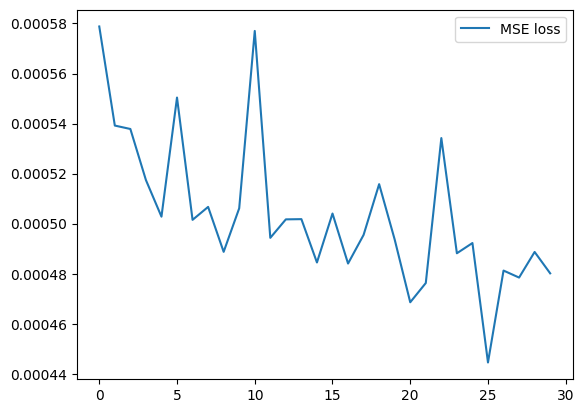

In [20]:
import matplotlib.pyplot as plt
plt.plot(mse.history['loss'][20:], label='MSE loss')
plt.legend()

In [ ]:
model.save('model/LSTM_freq.h5')

### Load Scaler & Model

In [ ]:
from keras.models import load_model
import joblib

model = load_model('model/LSTM_freq.h5')
scaler = joblib.load("model/freq_scaler.save")

In [ ]:
X_pred = df['tekanan_uap_masuk'][-184:-4].values
X_pred = X_pred.reshape((-1,1))
X_pred = scaler.transform(X_pred)
X_pred = X_pred.reshape((-1))
forecast = model.predict(X_pred.reshape((1, 180, 1)))

In [ ]:
look_back = 180
prediction_list = df["frekuensi"][-look_back:].values
arr = []
    
for _ in range(63):
    x = prediction_list[-look_back:]
    x = x.reshape((-1,1))
    x = scaler.transform(x)
    x = x.reshape((-1))
    x = x.reshape((1, look_back, 1))
#     out = model.predict(x)[0][0]
    out = model.predict(x)
    print(out[0][0])
    print(scaler.inverse_transform(out).reshape(-1))
    arr.append(scaler.inverse_transform(out).reshape((-1)))
    
    prediction_list = np.append(prediction_list, round(scaler.inverse_transform(out).reshape(-1)[0]))

In [ ]:
## Prediksi dengan Auto Data Loader

prediction = model.predict(test_generator)
prediction = prediction.reshape((-1,1))
prediction = scaler.inverse_transform(prediction)
prediction = prediction.reshape(-1)

In [ ]:
## Visualisasi Grafik

import plotly.graph_objects as go
prediction = model.predict(test_generator)

inverse_train = train.reshape((-1,1))
inverse_train = scaler.inverse_transform(inverse_train)
inverse_train = inverse_train.reshape(-1)
inverse_test = test.reshape((-1,1))
inverse_test = scaler.inverse_transform(inverse_test)
inverse_test = inverse_test.reshape(-1)
prediction = prediction.reshape((-1,1))
prediction = scaler.inverse_transform(prediction)
prediction = prediction.reshape(-1)

trace1 = go.Scatter(
    x = date_train,
    y = inverse_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test[180:],
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = inverse_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Prediksi Tekanan Uap Masuk",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Tekanan Uap Masuk"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()